# ФИНАЛЬНЫЙ ПРОЕКТ

### Задача:
Металлургический комбинат «Стальная птица» пытается снизить расходы на электроэнергию на этапе обработки стали. Эти расходы напрямую связаны с температурой сплава в ходе технологического процесса.

Необходим точный прогноз температуры сплава на следующий момент, чтобы иметь возможность эффективно управлять процессом нагрева, избегая излишнего расхода энергии.

Таким способом, с помощью модели прогноза температуры, предприятие сможет перейти к динамическому управлению процессом с целью повышения энергетической эффективности.

### Проблема, которую нужно взять в работу:

Основная проблема заключается в недостатке точности прогноза температуры сплава с помощью традиционных методов контроля. Эти модели плохо учитывают совокупное влияние нескольких технологических факторов (например, химический состав, время нагрева, расход энергии, свойства оборудования) на динамику температуры.

Это может привести к:

- излишне высокому расходу электроэнергии;

- недостаточно точно выведенной температуре, что влияет на качество готовой стали;

- потере ресурсов из-за несогласования процессов с расчетными моделями.

Таким способом, главный вызов заключается в создании точной модели прогноза температуры сплава с целью повышения точности контроля процесса и повышения энергетической эффективности.



## Загрузка данных

In [1]:
import pandas as pd
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import math
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor


from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer                     
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer



from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

RANDOM_STATE = 30625
TEST_SIZE = 0.25

In [2]:
def load_csv(filepath, parse_dates=None):
    try:
        df = pd.read_csv(filepath, parse_dates=parse_dates)
        print(f"✅ Успешно загружен: {filepath}")
        return df
    except FileNotFoundError:
        print(f"❌ Файл не найден: {filepath}")
    except ValueError as e:
        print(f"❌ Ошибка при загрузке {filepath}: {e}")
    except Exception as e:
        print(f"❌ Неожиданная ошибка при загрузке {filepath}: {e}")

parse_columns_bulk = [f'Bulk {i}' for i in range(1, 16)]
parse_columns_wire = [f'Wire {i}' for i in range(1, 10)]

data_arc_new = load_csv('/datasets/data_arc_new.csv', 
                        parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])

data_bulk_new = load_csv('/datasets/data_bulk_new.csv')

data_bulk_time_new = load_csv('/datasets/data_bulk_time_new.csv', 
                              parse_dates=parse_columns_bulk)

data_gas_new = load_csv('/datasets/data_gas_new.csv')

data_temp_new = load_csv('/datasets/data_temp_new.csv', 
                         parse_dates=['Время замера'])

data_wire_new = load_csv('/datasets/data_wire_new.csv')

data_wire_time_new = load_csv('/datasets/data_wire_time_new.csv', 
                              parse_dates=parse_columns_wire)


✅ Успешно загружен: /datasets/data_arc_new.csv
✅ Успешно загружен: /datasets/data_bulk_new.csv
✅ Успешно загружен: /datasets/data_bulk_time_new.csv
✅ Успешно загружен: /datasets/data_gas_new.csv
✅ Успешно загружен: /datasets/data_temp_new.csv
✅ Успешно загружен: /datasets/data_wire_new.csv
✅ Успешно загружен: /datasets/data_wire_time_new.csv


##  Исследовательский анализ и предобработка данных

In [3]:
def data_check(dt):
    print(dt.shape, '\n')
    print(dt.columns, '\n')
    print('Кол-во пропусков:\n', dt.isna().sum(), '\n')
    print('Кол-во дубликатов: ',dt.duplicated().sum(), '\n')
    print(dt.info(), '\n')
    print('\n')

In [4]:
def description_for_num_features(model, feature):
    print(model[feature].describe(), type(feature),'\n')
    if model is not data_bulk_new and model is not data_temp_new and model is not data_wire_new:
        plt.boxplot(model[feature], vert=False)
        #plt.xlim(0, dt_f_main[feature].describe().max())
        plt.title('График ящик с усами для ' + feature)
    plt.show()
    plt.hist(model[feature], bins=40)
    plt.title('Гистограмма для ' + feature)
    plt.ylabel('Частота')
    plt.xlabel(feature)
    plt.show()

In [5]:
# Запускаю проверку данных, чтобы определить наличие пропусков, а также основные статистики по колонкам
data_check(data_arc_new)

# Переименовываю колонки для удобства работы с данными
data_arc_new.columns = ['key', 'beginning_of_arc_heating', 'end_of_arc_heating', 'active_power', 'reactive_power']

# Просматриваю первые строки набора данных, чтобы подтвердить правильность преобразования колонок
data_arc_new.head(5)

(14876, 5) 

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object') 

Кол-во пропусков:
 key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64 

Кол-во дубликатов:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None 





,key,beginning_of_arc_heating,end_of_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64 <class 'str'> 



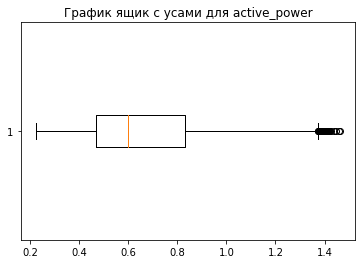

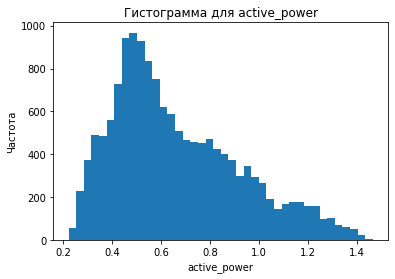

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64 <class 'str'> 



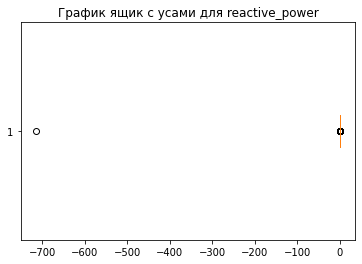

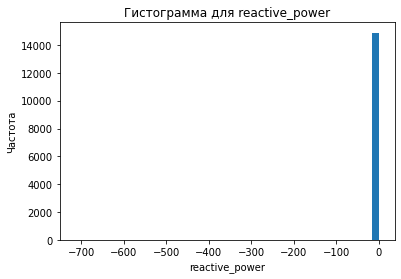

In [6]:
# Получаю описание статистических характеристик по количественным колонкам —
# это даст понимание характера данных и наличие аномалий
for j in data_arc_new.select_dtypes(include='float').columns.tolist():
    description_for_num_features(data_arc_new, j)

In [7]:
# В ходе просмотра данных увидел аномалию: minimum reactive_power имеет необычно негативное значение
# Всё равно что ошибка в документировании замера 
# Поэтому я изменил эту строку, убрав -715 и оставив цифры после точки
data_arc_new[data_arc_new['reactive_power'] == data_arc_new['reactive_power'].min()]

,key,beginning_of_arc_heating,end_of_arc_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [8]:
data_arc_new.loc[data_arc_new['reactive_power'] == data_arc_new['reactive_power'].min(), 'reactive_power'] = 0.479924

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64 <class 'str'> 



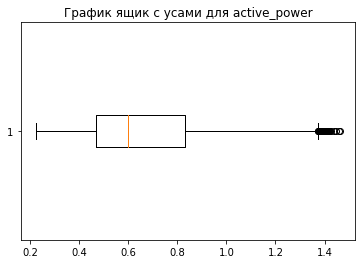

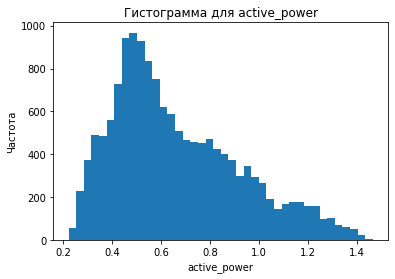

count    14876.000000
mean         0.487115
std          0.197606
min          0.153777
25%          0.337192
50%          0.441667
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64 <class 'str'> 



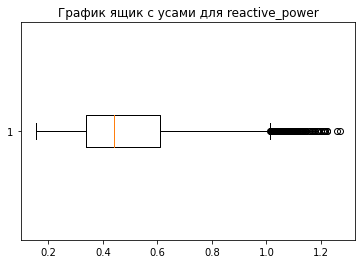

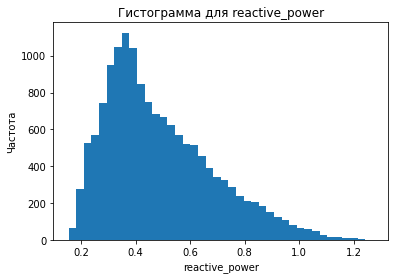

In [9]:
# Повторно вызываю описание колонок с целью проконтролировать изменения
for j in data_arc_new.select_dtypes(include='float').columns.tolist():
    description_for_num_features(data_arc_new, j)

In [10]:
# Запускаю анализ набора с информацией по сыпучему материалу, чтобы определить наличие пропусков и основные статистики по колонкам
data_check(data_bulk_new)

# Просматриваю первые строки набора данных, чтобы иметь общее понимание структуры
data_bulk_new.head(5)

(3129, 16) 

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object') 

Кол-во пропусков:
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64 

Кол-во дубликатов:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   2

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64 <class 'str'> 



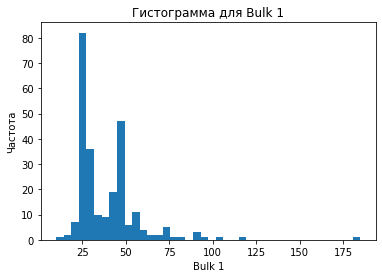

count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64 <class 'str'> 



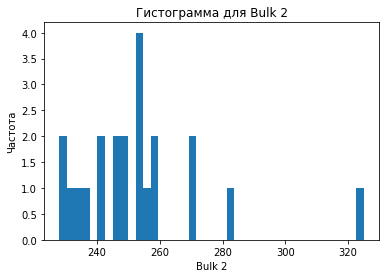

count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64 <class 'str'> 



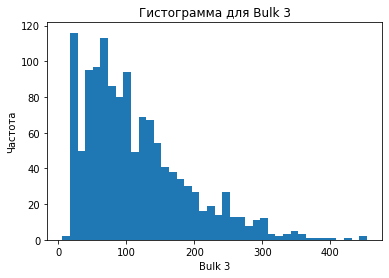

count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64 <class 'str'> 



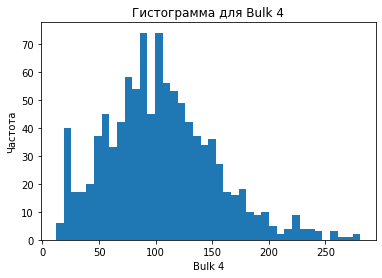

count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64 <class 'str'> 



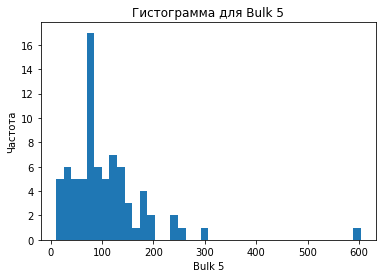

count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64 <class 'str'> 



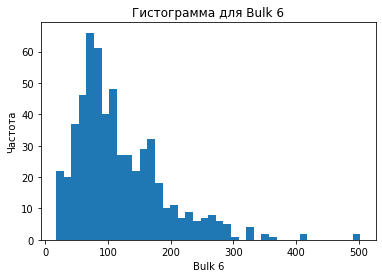

count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64 <class 'str'> 



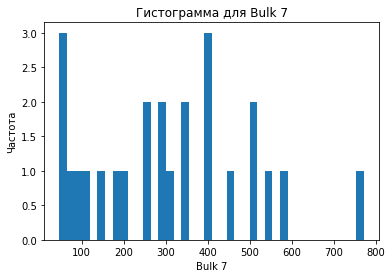

count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64 <class 'str'> 



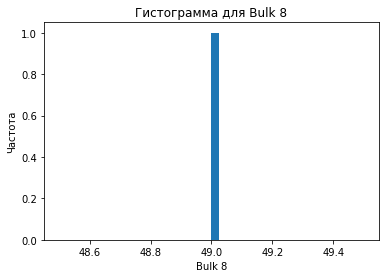

count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64 <class 'str'> 



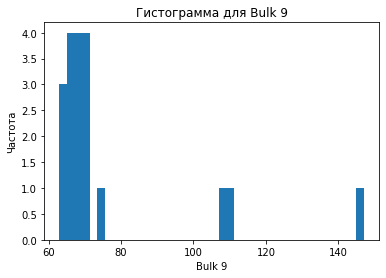

count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64 <class 'str'> 



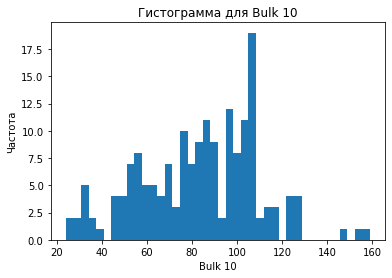

count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64 <class 'str'> 



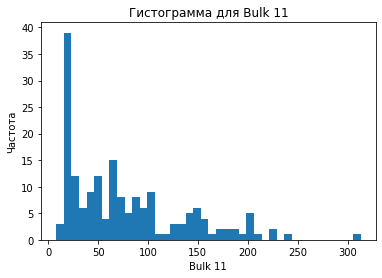

count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64 <class 'str'> 



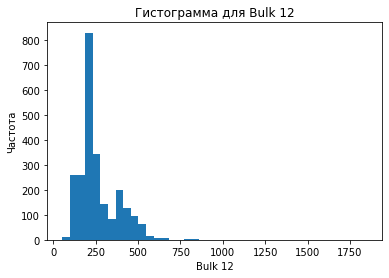

count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64 <class 'str'> 



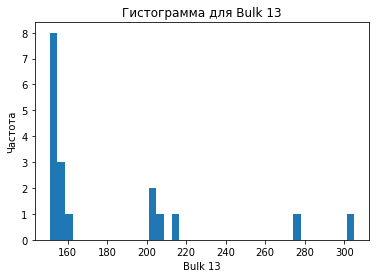

count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64 <class 'str'> 



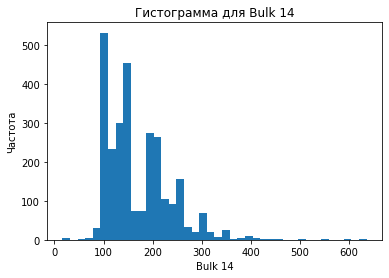

count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64 <class 'str'> 



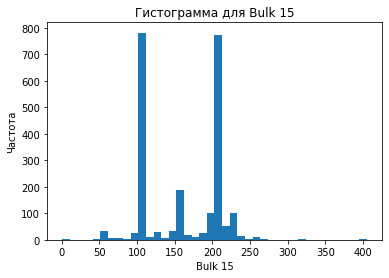

In [11]:
# Получаю описание колонок с количественными данными для контроля качества
for j in data_bulk_new.select_dtypes(include='float').columns.tolist():
    description_for_num_features(data_bulk_new, j)

In [12]:
# В ходе просмотра также хочу определить, в каких колонках существуют пропуски
# (с количеством > 3000)
data_bulk_new.columns[data_bulk_new.isna().sum() > 3000]


Index(['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13'], dtype='object')

In [13]:
# Запускаю анализ также по набору с информацией о сыпучем материале с временем
data_check(data_bulk_time_new)

data_bulk_time_new.head(5)

(3129, 16) 

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object') 

Кол-во пропусков:
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64 

Кол-во дубликатов:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[n

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [14]:
# Запускаю анализ по набору с информацией о расходе газа
data_check(data_gas_new)

# Переименовываю колонку с целью стандартизации названия
data_gas_new.columns = ['key', 'gas_1']

# Просматриваю первые строки набора с информацией о расходе газа
data_gas_new.head(5)

(3239, 2) 

Index(['key', 'Газ 1'], dtype='object') 

Кол-во пропусков:
 key      0
Газ 1    0
dtype: int64 

Кол-во дубликатов:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None 





,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64 <class 'str'> 



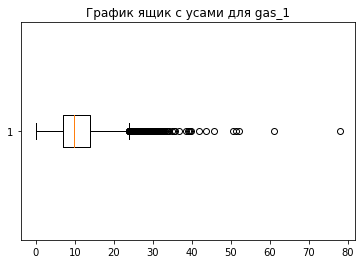

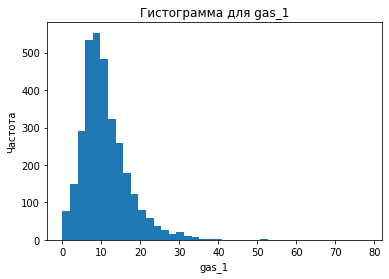

In [15]:
# Получаем описание колонок с количественными данными по расходу газа
for j in data_gas_new.select_dtypes(include='float').columns.tolist():
    description_for_num_features(data_gas_new, j)

In [16]:
# Запускаю анализ набора с информацией о температуре стали
data_check(data_temp_new)
# Переименовываю колонки с целью стандартизации названия
data_temp_new.columns = ['key', 'measurement_time', 'temperature']

# Просматриваю первые строки набора с информацией о температуре
data_temp_new.head(6)

(18092, 3) 

Index(['key', 'Время замера', 'Температура'], dtype='object') 

Кол-во пропусков:
 key                0
Время замера       0
Температура     3427
dtype: int64 

Кол-во дубликатов:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
None 





,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64 <class 'str'> 



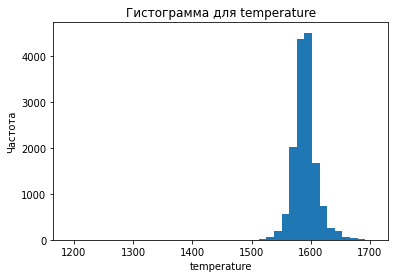

In [17]:
# Получаем описание колонок с количественными данными по температуре
for j in data_temp_new.select_dtypes(include='float').columns.tolist():
    description_for_num_features(data_temp_new, j)

In [18]:
# Запускаю анализ набора с информацией о проволоке
data_check(data_wire_new)

data_wire_new.head(5)

(3081, 10) 

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object') 

Кол-во пропусков:
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64 

Кол-во дубликатов:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None 





,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64 <class 'str'> 



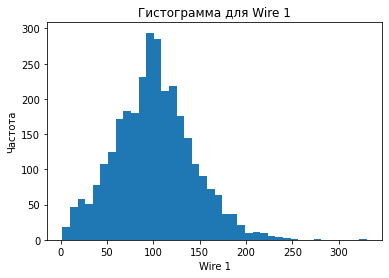

count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64 <class 'str'> 



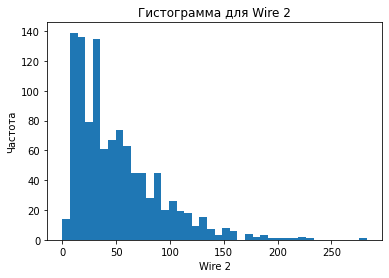

count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64 <class 'str'> 



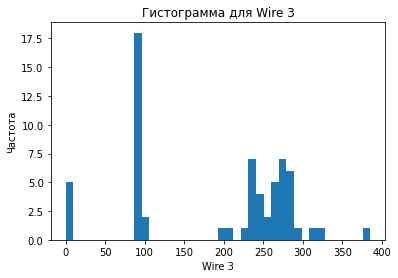

count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64 <class 'str'> 



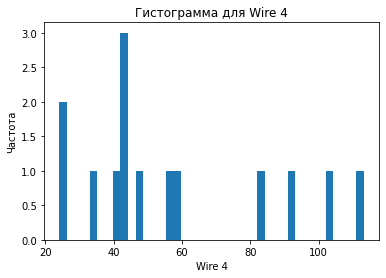

count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64 <class 'str'> 



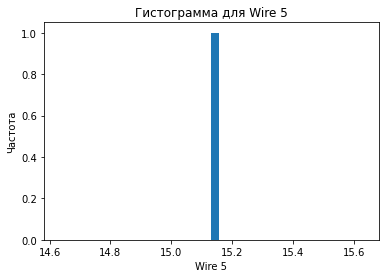

count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64 <class 'str'> 



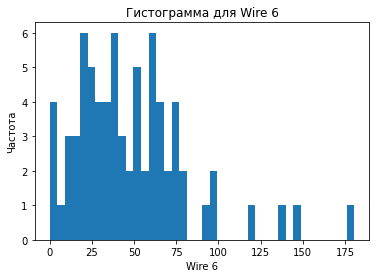

count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64 <class 'str'> 



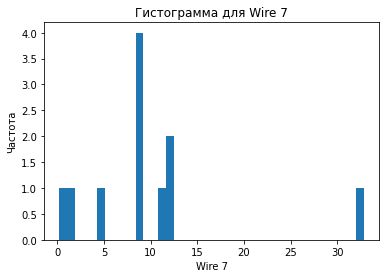

count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64 <class 'str'> 



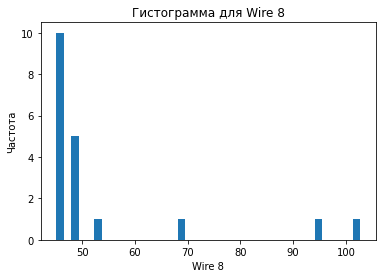

count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64 <class 'str'> 



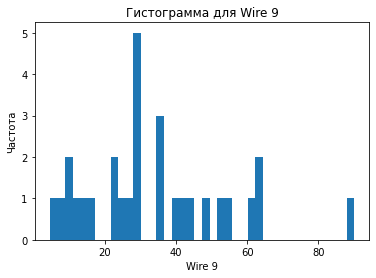

In [19]:
# Получаем описание колонок с количественными данными по проволоке
for j in data_wire_new.select_dtypes(include='float').columns.tolist():
    description_for_num_features(data_wire_new, j)

In [20]:
# Запускаю анализ набора с информацией о проволоке с временем
data_check(data_wire_time_new)

data_wire_time_new.head(5)

(3081, 10) 

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object') 

Кол-во пропусков:
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64 

Кол-во дубликатов:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [21]:
# В ходе просмотра данных было принято убрать колонки с большим количеством пропусков,
# так как они вносят шум и снижают точность модели
bulk_to_drop = ['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']
# Соответственно, очищаем набор с информацией по сыпучему материалу...
data_bulk_new = data_bulk_new.drop(columns=bulk_to_drop)
# …и по сыпучему материалу с информацией о времени
data_bulk_time_new = data_bulk_time_new.drop(columns=bulk_to_drop)



# Аналогично очищаем набор с информацией по проволоке
wire_to_drop = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
# …и по проволоке с информацией о времени
data_wire_new = data_wire_new.drop(columns=wire_to_drop)
data_wire_time_new = data_wire_time_new.drop(columns=wire_to_drop)



print(f"Bulk признаки после удаления: {data_bulk_new.shape[1] - 1}")
print(f"Wire признаки после удаления: {data_wire_new.shape[1] - 1}")


Bulk признаки после удаления: 9
Wire признаки после удаления: 2


Все эти столбцы не имеют никакой ценности, потому что ~95% данных - это пропуски, которые, если заменить их на 0, станут просто шумом, а не важными данными, поэтому я их удалил

In [22]:
# Заполняем пропуски нулями, чтобы модели могли с ними нормально работать
# В данном случае 0 важны, потому что это показатель того, что материал не добавляли
data_bulk_new.fillna(0, inplace=True)
data_wire_new.fillna(0, inplace=True)

In [23]:
data_temp_new

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [24]:
data_temp_new.tail(30)

,key,measurement_time,temperature
18062,3237,2019-09-06 11:35:38,NaN
18063,3237,2019-09-06 11:41:07,NaN
18064,3237,2019-09-06 11:46:22,NaN
18065,3237,2019-09-06 11:51:29,NaN
18066,3237,2019-09-06 11:55:45,NaN
18067,3238,2019-09-06 12:16:15,1584.0
18068,3238,2019-09-06 12:22:00,NaN
18069,3238,2019-09-06 12:28:35,NaN
18070,3238,2019-09-06 12:34:37,NaN
18071,3239,2019-09-06 14:16:50,1598.0


In [25]:
data_temp_new = data_temp_new[~data_temp_new['key'].isin(
                               data_temp_new.loc[data_temp_new['temperature'].isna(), 'key'].unique())
                              ]

In [26]:
data_temp_new

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [27]:
print('Пропущенных значений после заполнения: \n', data_temp_new.isna().sum())

Пропущенных значений после заполнения: 
 key                 0
measurement_time    0
temperature         0
dtype: int64


In [28]:
data_temp_new[data_temp_new['temperature'] < 1400]

,key,measurement_time,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0


In [29]:
data_temp_new = data_temp_new[data_temp_new['temperature'] >= 1400]

In [30]:
data_temp_new

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-success" style="border-color: green; border-radius: 5px">
<b> КОММЕНТАРИЙ МЕНТОРА 2</b><br>супер! Но удалять надо не просто строку, а ковш в целом - ведь объект моделирования - ковш. Сейчас строк-пропусков нет, но сами ковши осталичь ещё. Но посмотрим далее.

### ВЫВОДЫ ПО ЗАГРУЗКЕ ДАННЫХ:

Во время работы были загруздены 7 наборов данных из CSV файлов:

- data_arc_new (14876 записей)

- data_bulk_new (3129 записей)

- data_bulk_time_new (3129 записей)

- data_gas_new (3239 записей)

- data_temp_new (18092 записи)

- data_wire_new (3081 запись)

- data_wire_time_new (3081 запись)


### Визуализация с помощью boxplot и гистограмм:

Для количественных колонок были выведены графики:

Boxplot (для просмотра выбросов)

Histogram (для просмотра распределения)

Это позволило определить аномалии в данных (например, аномально минимальная реактивная мощность) и заполненность колонок

### Чистка данных:

В колонках с большим количеством пропусков были вычищены из набора:

Колонки с Bulk (например, "Bulk 2", "Bulk 5") с большим количеством пропусов.

Колонки с Wire с большим количеством пропусков.

В других колонках с меньшим количеством пропущенных значений заполнены нулями

Чистка данных повысила точность, качество и воспроизводимость аналитики

Мы исключили колоноки с недостаточным количеством данных, что снизило уровень шума

Удвлил полностью неинформативную часть в data_temp_new

### Резюме:

В ходе работы были проанализированы свойства данных, очищены ошибки, заполнены пропуски, вычищены колоноки с недостаточным количеством информации.

Результат: готовая структура данных с заполненной информацией, что даст точно выстроенные модели, с точными расчетами на следующий аналитический процесс.

## Объединение данных

In [31]:
data_arc_time_begin = data_arc_new.groupby('key')['beginning_of_arc_heating'].first().reset_index()
data_arc_time_end = data_arc_new.groupby('key')['end_of_arc_heating'].last().reset_index()

In [32]:
new_temp_first = data_temp_new.groupby('key')['measurement_time', 'temperature'].first().reset_index()
new_temp_last = data_temp_new.groupby('key')['measurement_time', 'temperature'].last().reset_index()

/tmp/ipykernel_31/976805965.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_temp_first = data_temp_new.groupby('key')['measurement_time', 'temperature'].first().reset_index()
/tmp/ipykernel_31/976805965.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_temp_last = data_temp_new.groupby('key')['measurement_time', 'temperature'].last().reset_index()


In [33]:
data_temp_new.head(10)

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [34]:
data_temp = new_temp_first.merge(new_temp_last, on='key')

In [35]:
data_temp['duration_minutes_temp'] = (
    data_temp['measurement_time_y'] - data_temp['measurement_time_x']
).dt.total_seconds()

data_temp = data_temp.drop(['measurement_time_x','measurement_time_y'], axis = 1)

data_temp

,key,temperature_x,temperature_y,duration_minutes_temp
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0
...,...,...,...,...
2472,2495,1570.0,1591.0,1380.0
2473,2496,1554.0,1591.0,1705.0
2474,2497,1571.0,1589.0,962.0
2475,2498,1591.0,1594.0,1520.0


In [36]:
dta = data_arc_new.copy()

In [37]:
dta['diff'] =(
    data_arc_new['end_of_arc_heating'] - data_arc_new['beginning_of_arc_heating']
).dt.total_seconds()

In [38]:
dta = dta.groupby('key')['diff'].sum().reset_index()

In [39]:
dta

,key,diff
0,1,1098.0
1,2,811.0
2,3,655.0
3,4,741.0
4,5,869.0
...,...,...
3209,3237,909.0
3210,3238,546.0
3211,3239,1216.0
3212,3240,839.0


In [40]:
data_duration = data_arc_time_begin.merge(data_arc_time_end, on='key')

data_duration['duration_minutes_arc'] = (
    data_duration['end_of_arc_heating'] - data_duration['beginning_of_arc_heating']
).dt.total_seconds()

data_duration = data_duration.drop(['beginning_of_arc_heating','end_of_arc_heating'], axis = 1)

data_duration

,key,duration_minutes_arc
0,1,1583.0
1,2,1144.0
2,3,1525.0
3,4,1093.0
4,5,1362.0
...,...,...
3209,3237,1350.0
3210,3238,910.0
3211,3239,2930.0
3212,3240,3524.0


In [41]:
data_all = (data_arc_new.drop(['beginning_of_arc_heating', 'end_of_arc_heating'], axis = 1)
            .groupby('key')
            .last()
            .reset_index()
            .copy())


data_all = data_all.merge(data_bulk_new, on='key', how='inner')
data_all = data_all.merge(data_wire_new, on='key', how='inner')
data_all = data_all.merge(data_gas_new, on='key', how='inner')
data_all = data_all.merge(dta, on='key', how='inner')
data_all = data_all.merge(data_temp, on='key', how='inner')
print("Количество колонок в слитом DataFrame :", data_all.shape[1])
print("Количество записей в слитом DataFrame :", data_all.shape[0])

Количество колонок в слитом DataFrame : 19
Количество записей в слитом DataFrame : 2329


In [42]:
data_all

,key,active_power,reactive_power,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,gas_1,diff,temperature_x,temperature_y,duration_minutes_temp
0,1,0.867133,0.643691,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,1098.0,1571.0,1613.0,1714.0
1,2,0.786322,0.542517,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,811.0,1581.0,1602.0,1265.0
2,3,0.421693,0.272562,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,655.0,1596.0,1599.0,1753.0
3,4,0.864995,0.654661,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,741.0,1601.0,1625.0,1220.0
4,5,0.892957,0.660807,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,869.0,1576.0,1602.0,1536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,0.862070,0.661810,0.0,21.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,89.150879,0.00000,7.125735,723.0,1570.0,1591.0,1380.0
2325,2496,1.309449,0.824095,0.0,0.0,63.0,0.0,122.0,0.0,256.0,129.0,226.0,114.179527,0.00000,9.412616,940.0,1554.0,1591.0,1705.0
2326,2497,1.270521,0.906829,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0,94.086723,9.04800,6.271699,569.0,1571.0,1589.0,962.0
2327,2498,0.508786,0.363916,0.0,90.0,0.0,0.0,101.0,0.0,206.0,129.0,207.0,118.110717,0.00000,14.953657,750.0,1591.0,1594.0,1520.0


In [43]:
data_check(data_all)

(2329, 19) 

Index(['key', 'active_power', 'reactive_power', 'Bulk 1', 'Bulk 3', 'Bulk 4',
       'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15',
       'Wire 1', 'Wire 2', 'gas_1', 'diff', 'temperature_x', 'temperature_y',
       'duration_minutes_temp'],
      dtype='object') 

Кол-во пропусков:
 key                      0
active_power             0
reactive_power           0
Bulk 1                   0
Bulk 3                   0
Bulk 4                   0
Bulk 6                   0
Bulk 10                  0
Bulk 11                  0
Bulk 12                  0
Bulk 14                  0
Bulk 15                  0
Wire 1                   0
Wire 2                   0
gas_1                    0
diff                     0
temperature_x            0
temperature_y            0
duration_minutes_temp    0
dtype: int64 

Кол-во дубликатов:  0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 19 columns):
 #   Column             

count    2329.000000
mean        0.659182
std         0.257090
min         0.228852
25%         0.458905
50%         0.594423
75%         0.823710
max         1.463773
Name: active_power, dtype: float64 <class 'str'> 



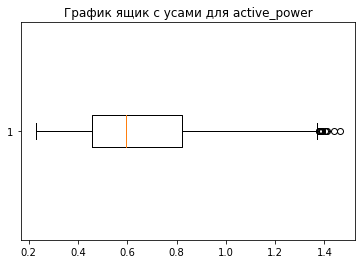

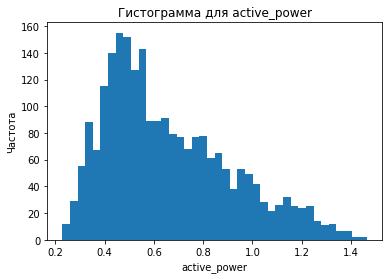

count    2329.000000
mean        0.484976
std         0.194771
min         0.153777
25%         0.336211
50%         0.440120
75%         0.609217
max         1.188563
Name: reactive_power, dtype: float64 <class 'str'> 



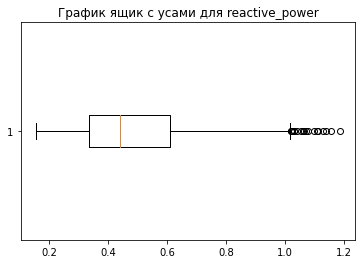

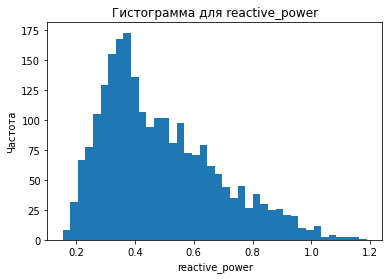

count    2329.000000
mean        3.427651
std        12.412132
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: Bulk 1, dtype: float64 <class 'str'> 



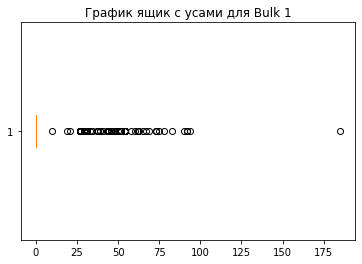

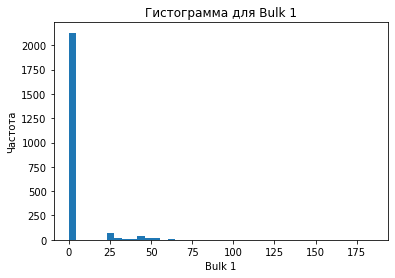

count    2329.000000
mean       47.348218
std        75.310430
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: Bulk 3, dtype: float64 <class 'str'> 



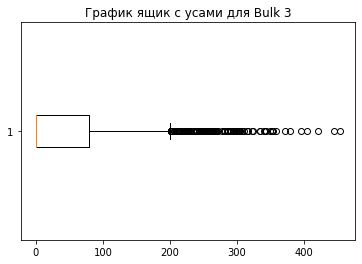

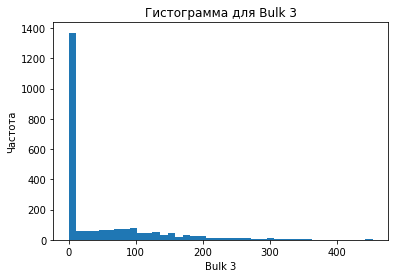

count    2329.000000
mean       37.303564
std        58.643238
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: Bulk 4, dtype: float64 <class 'str'> 



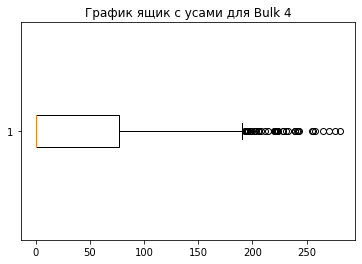

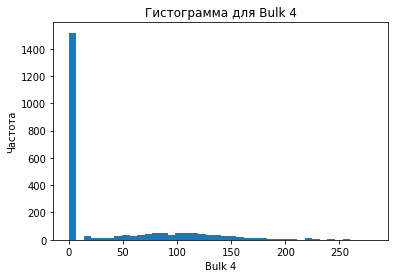

count    2329.000000
mean       22.430228
std        55.790873
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: Bulk 6, dtype: float64 <class 'str'> 



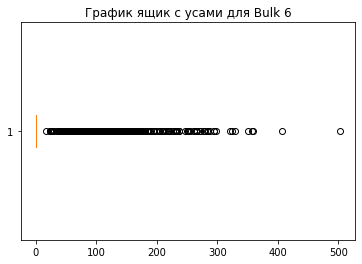

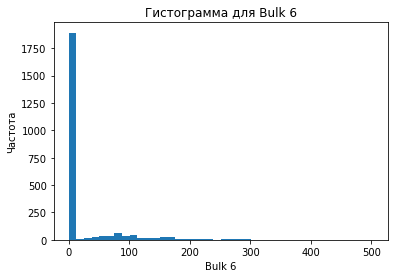

count    2329.000000
mean        5.052812
std        20.917800
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: Bulk 10, dtype: float64 <class 'str'> 



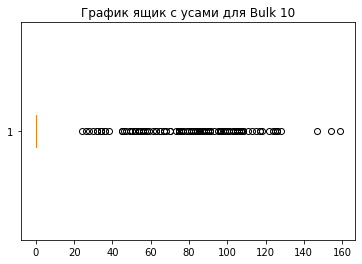

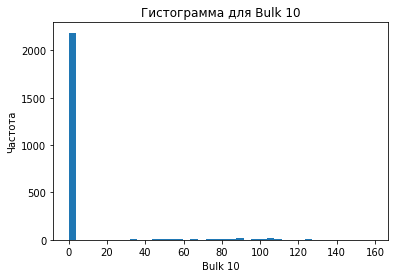

count    2329.000000
mean        4.245170
std        22.515487
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: Bulk 11, dtype: float64 <class 'str'> 



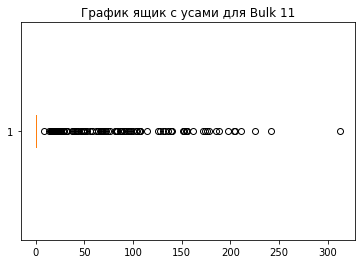

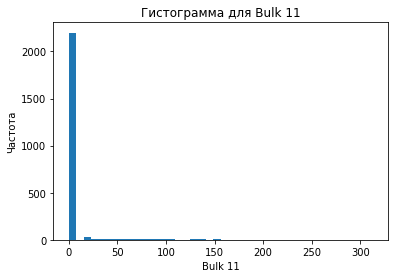

count    2329.000000
mean      208.415629
std       157.062272
min         0.000000
25%       105.000000
50%       206.000000
75%       282.000000
max      1849.000000
Name: Bulk 12, dtype: float64 <class 'str'> 



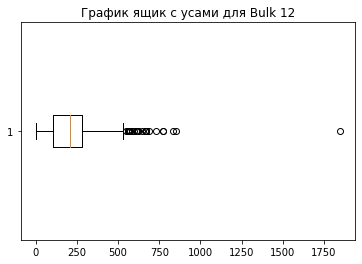

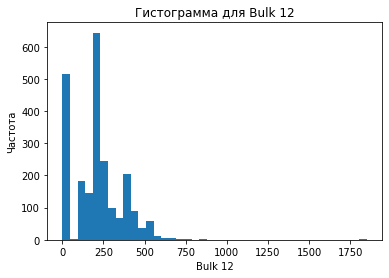

count    2329.000000
mean      153.853585
std        81.404354
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: Bulk 14, dtype: float64 <class 'str'> 



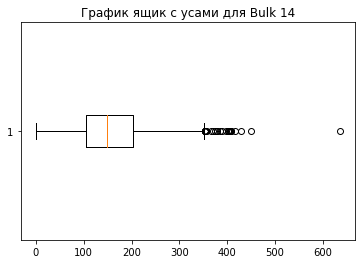

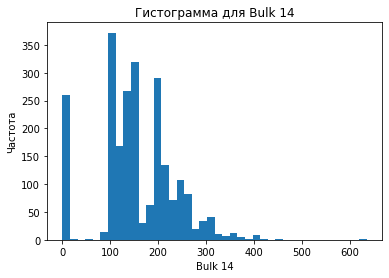

count    2329.000000
mean      119.952769
std        84.640443
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: Bulk 15, dtype: float64 <class 'str'> 



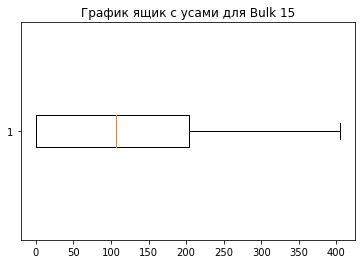

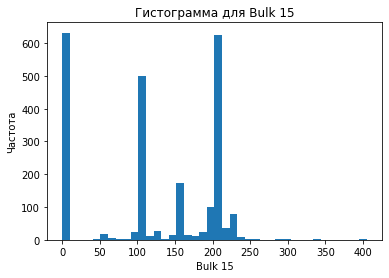

count    2329.000000
mean      102.443601
std        43.539993
min         0.000000
25%        73.207679
50%       101.119201
75%       128.091599
max       330.314424
Name: Wire 1, dtype: float64 <class 'str'> 



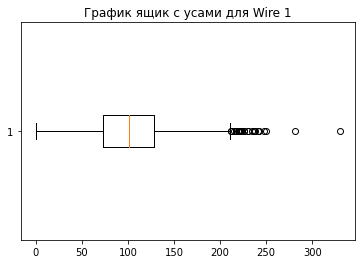

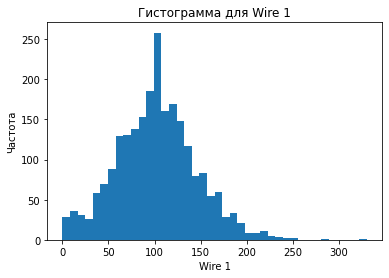

count    2329.000000
mean       17.609859
std        33.624771
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: Wire 2, dtype: float64 <class 'str'> 



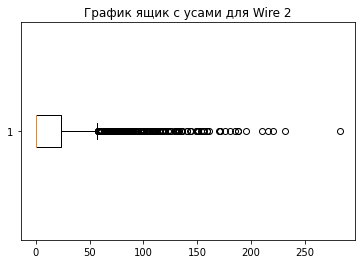

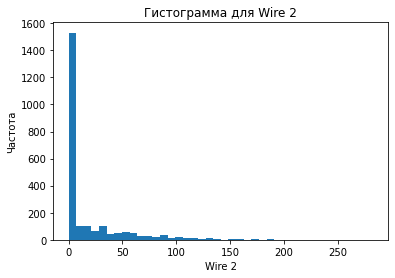

count    2329.000000
mean       11.375600
std         6.392041
min         0.008399
25%         7.282948
50%        10.100950
75%        14.216688
max        77.995040
Name: gas_1, dtype: float64 <class 'str'> 



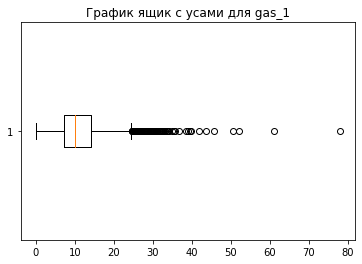

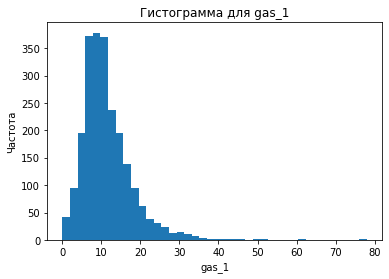

count    2329.000000
mean      807.647488
std       340.838388
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: diff, dtype: float64 <class 'str'> 



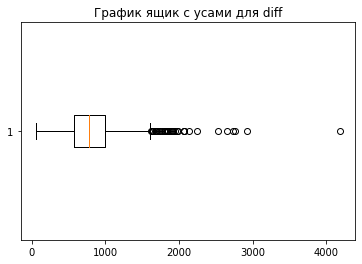

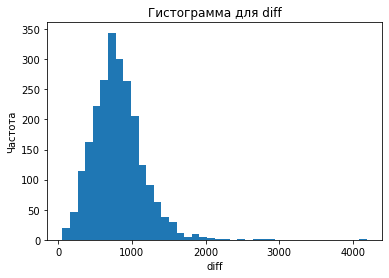

count    2329.000000
mean     1587.386003
std        23.619841
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: temperature_x, dtype: float64 <class 'str'> 



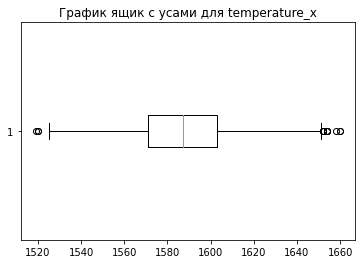

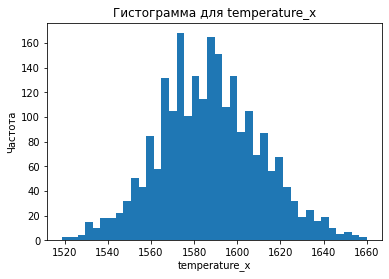

count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temperature_y, dtype: float64 <class 'str'> 



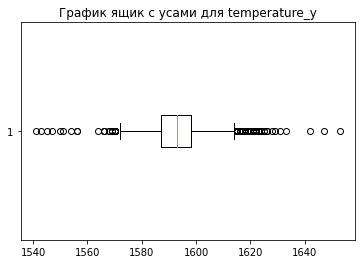

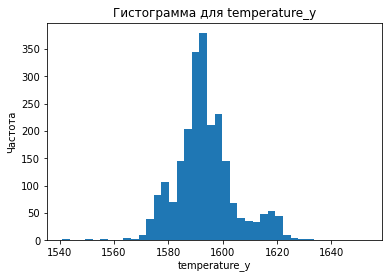

count     2329.000000
mean      2321.810219
std       1385.191527
min        270.000000
25%       1579.000000
50%       2045.000000
75%       2791.000000
max      23674.000000
Name: duration_minutes_temp, dtype: float64 <class 'str'> 



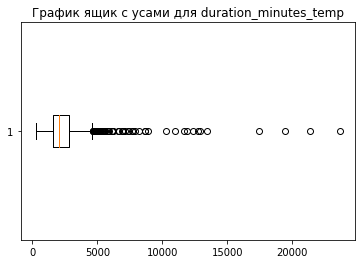

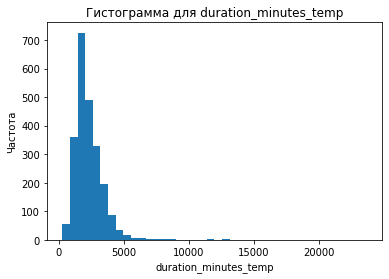

In [44]:
# Получаем список колонок с количественными особенностями (тип float)
for j in data_all.select_dtypes(include='float').columns.tolist():
    description_for_num_features(data_all, j)

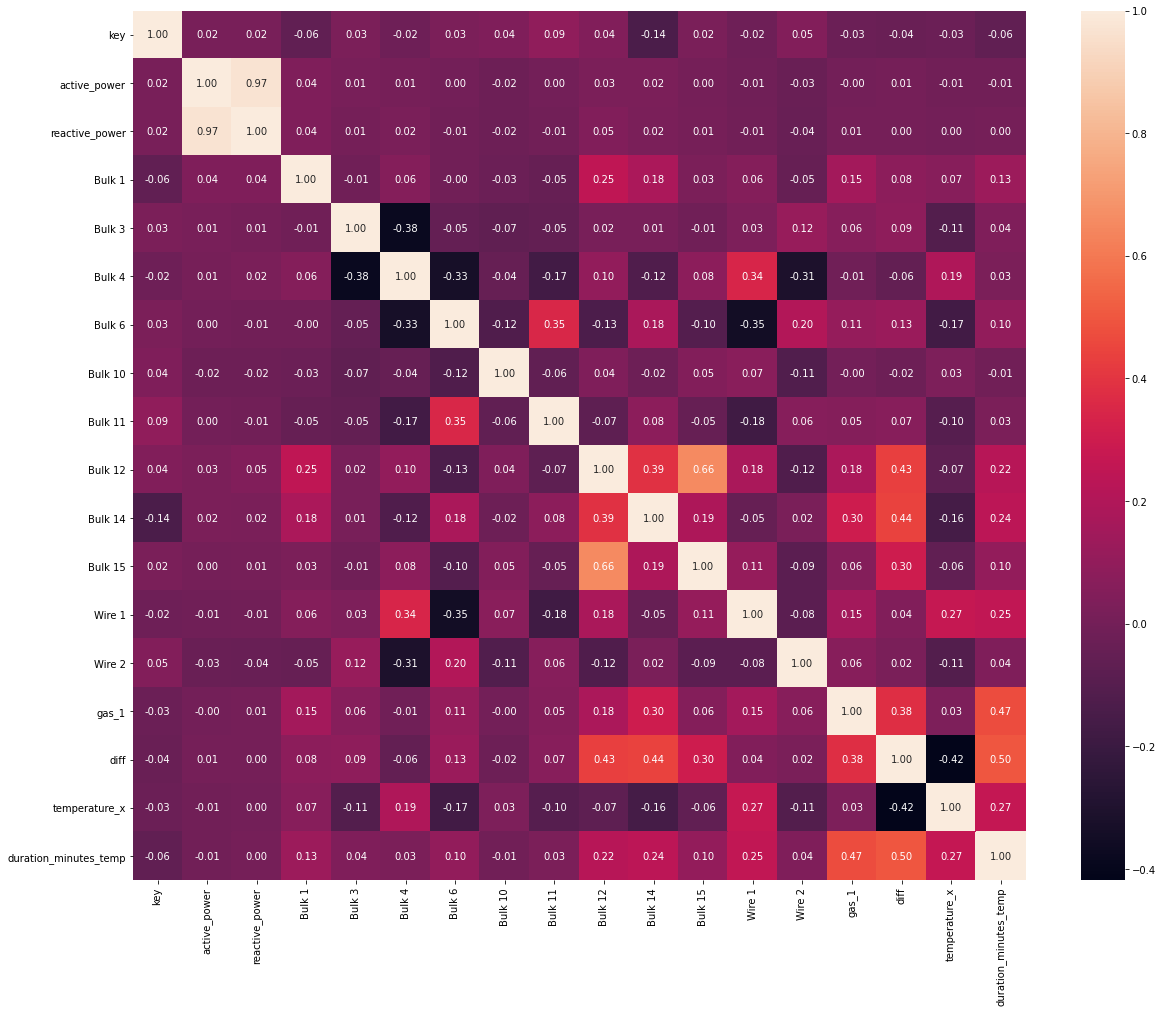

In [45]:
# Визуализация матрицы корреляций с помощью тепловой карты
plt.subplots(figsize=(20, 16))

sns.heatmap(data_all.drop(['temperature_y'], axis=1).corr(method='spearman'), annot=True, fmt='.2f')

plt.show()

In [46]:
# Исключаем колонки 'Bulk 12' и 'reactive_power', так как они сильно коррелирует с 'Bulk 15' (высокая корреляция),
# и 'active_power' соотв., что может привести к мультиколлинеарности и ухудшить качество модели.
data_all = data_all.drop(['reactive_power', 'Bulk 12'], axis=1)

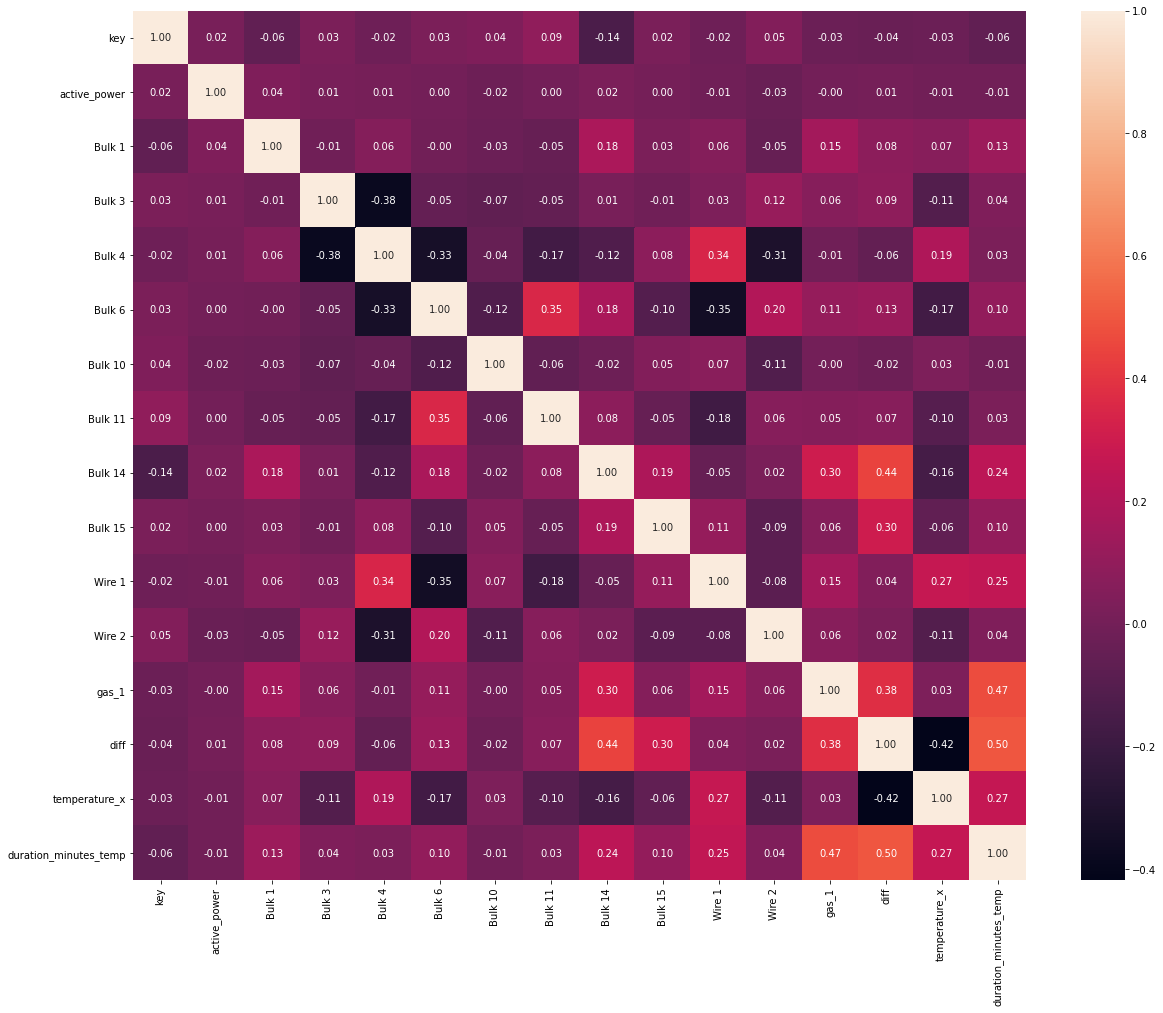

In [47]:
# Визуализация матрицы корреляций с помощью тепловой карты
plt.subplots(figsize=(20, 16))

sns.heatmap(data_all.drop(['temperature_y'], axis=1).corr(method='spearman'), annot=True, fmt='.2f')

plt.show()

In [48]:
data_all

,key,active_power,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 14,Bulk 15,Wire 1,Wire 2,gas_1,diff,temperature_x,temperature_y,duration_minutes_temp
0,1,0.867133,0.0,0.0,43.0,0.0,0.0,0.0,150.0,154.0,60.059998,0.00000,29.749986,1098.0,1571.0,1613.0,1714.0
1,2,0.786322,0.0,0.0,73.0,0.0,0.0,0.0,149.0,154.0,96.052315,0.00000,12.555561,811.0,1581.0,1602.0,1265.0
2,3,0.421693,0.0,0.0,34.0,0.0,0.0,0.0,152.0,153.0,91.160157,0.00000,28.554793,655.0,1596.0,1599.0,1753.0
3,4,0.864995,0.0,0.0,81.0,0.0,0.0,0.0,153.0,154.0,89.063515,0.00000,18.841219,741.0,1601.0,1625.0,1220.0
4,5,0.892957,0.0,0.0,78.0,0.0,0.0,0.0,151.0,152.0,89.238236,9.11456,5.413692,869.0,1576.0,1602.0,1536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,0.862070,0.0,21.0,0.0,0.0,90.0,0.0,129.0,223.0,89.150879,0.00000,7.125735,723.0,1570.0,1591.0,1380.0
2325,2496,1.309449,0.0,0.0,63.0,0.0,122.0,0.0,129.0,226.0,114.179527,0.00000,9.412616,940.0,1554.0,1591.0,1705.0
2326,2497,1.270521,0.0,0.0,85.0,0.0,0.0,0.0,124.0,226.0,94.086723,9.04800,6.271699,569.0,1571.0,1589.0,962.0
2327,2498,0.508786,0.0,90.0,0.0,0.0,101.0,0.0,129.0,207.0,118.110717,0.00000,14.953657,750.0,1591.0,1594.0,1520.0


## Обучение моделей машинного обучения

In [49]:
X = data_all.drop(['key', 'temperature_y'], axis=1)
y = data_all['temperature_y']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_SIZE)

In [51]:
preprocessor = MinMaxScaler()

In [52]:
pipe_xgbr = Pipeline([
    ('model', XGBRegressor(random_state=RANDOM_STATE))
])

pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(random_state=RANDOM_STATE))
])

pipe_rf = Pipeline([
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

pipe_catboost = Pipeline([
    ('model', CatBoostRegressor(random_state=RANDOM_STATE, silent=True))
])

pipe_lgbm = Pipeline([
    ('model', LGBMRegressor(random_state=RANDOM_STATE))
])

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression()) 
])

In [53]:
param_dist_xgbr = {
    'model__n_estimators': [500, 1000],
    'model__max_depth': [3, 4],
    'model__min_child_weight': [1, 5],
    'model__subsample': [0.7, 0.8],
    'model__colsample_bytree': [0.7, 0.8],
    'model__lambda': [0, 0.5],
    'model__alpha': [0, 0.5],
    'model__learning_rate': [0.01, 0.05],
}

param_dist_ridge = {
    'model__alpha': np.logspace(-3, 3, 7)
}

param_dist_rf = {
    'model__n_estimators': [200, 400, 600, 800, 1000],
    'model__max_depth': [10, 20, 30, 40, 50, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5, 0.7]
}

param_dist_catboost = {
    'model__depth': [4, 6, 8, 10],
    'model__learning_rate': [0.005, 0.01, 0.05],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__border_count': [32, 64, 128, 256],
    'model__iterations': [1000, 1500, 2000, 2500],
}


param_dist_lgbm = {
    'model__max_depth': [5, 10, 15, 20],
    'model__num_leaves': [31, 50, 100, 150, 200],
    'model__min_data_in_leaf': [10, 20, 50],
    'model__feature_fraction': [0.7, 0.8, 0.9],
    'model__lambda_l1': [0, 0.5, 1],
    'model__lambda_l2': [0, 0.5, 1],
    'model__n_estimators': [1000, 1500, 2000, 2500],
    'model__learning_rate': [0.005, 0.01, 0.05],
}



param_dist_lr = {
    'model__fit_intercept': [True, False],
}


In [54]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [55]:
search_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_dist_lr,
    n_iter=2,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)
search_lr.fit(X_train, y_train)
print("LinearRegression CV Mean Absolute Error =", -search_lr.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
LinearRegression CV Mean Absolute Error = 5.904653060521568


In [56]:
search_ridge = RandomizedSearchCV(
    pipe_ridge,
    param_distributions=param_dist_ridge,
    n_iter=50,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)
search_ridge.fit(X_train, y_train)
print("Ridge CV Mean Absolute Error =", -search_ridge.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 7 is smaller than n_iter=50. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Ridge CV Mean Absolute Error = 5.90464762076642


In [57]:
search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)
search_rf.fit(X_train, y_train)
print("Random Forest CV Mean Absolute Error =", -search_rf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest CV Mean Absolute Error = 6.108807493886675


In [58]:
search_catboost = RandomizedSearchCV(
    pipe_catboost,
    param_distributions=param_dist_catboost,
    n_iter=5,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)

search_catboost.fit(X_train, y_train)
print("CatBoost CV Mean Absolute Error =", -search_catboost.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END model__border_count=32, model__depth=4, model__iterations=1500, model__l2_leaf_reg=7, model__learning_rate=0.01; total time=   1.7s
[CV] END model__border_count=32, model__depth=4, model__iterations=1500, model__l2_leaf_reg=7, model__learning_rate=0.01; total time=   1.8s
[CV] END model__border_count=32, model__depth=4, model__iterations=1500, model__l2_leaf_reg=7, model__learning_rate=0.01; total time=   1.8s
[CV] END model__border_count=32, model__depth=4, model__iterations=1500, model__l2_leaf_reg=7, model__learning_rate=0.01; total time=   1.7s
[CV] END model__border_count=32, model__depth=4, model__iterations=1500, model__l2_leaf_reg=7, model__learning_rate=0.01; total time=   1.7s
[CV] END model__border_count=32, model__depth=4, model__iterations=2500, model__l2_leaf_reg=3, model__learning_rate=0.05; total time=   2.3s
[CV] END model__border_count=32, model__depth=4, model__iterations=2500, model__l2_leaf_reg=3,

## Выбор лучшей модели

In [59]:
scores = {
    #'XGBoost': -search_xgbr.best_score_, 
    'Ridge': -search_ridge.best_score_, 
    'Random Forest': -search_rf.best_score_,
    'CatBoost': -search_catboost.best_score_, 
    #'LGBM': -search_lgbm.best_score_, 
    'LinearRegression': -search_lr.best_score_
}

best_name = min(scores, key=scores.get)

#if best_name == 'XGBoost':
  #  best_model = search_xgbr.best_estimator_
if best_name == 'Ridge':
    best_model = search_ridge.best_estimator_
elif best_name == 'CatBoost':
    best_model = search_catboost.best_estimator_
#elif best_name == 'LGBM':
 #   best_model = search_lgbm.best_estimator_
elif best_name == 'LinearRegression':
    best_model = search_lr.best_estimator_
else:
    best_model = search_rf.best_estimator_

print("Лучшая модель :", best_name)

Лучшая модель : CatBoost


In [60]:
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("MAE на тесте =", mae)

MAE на тесте = 6.186871977474273


100%|===================| 1740/1746 [00:50<00:00]        

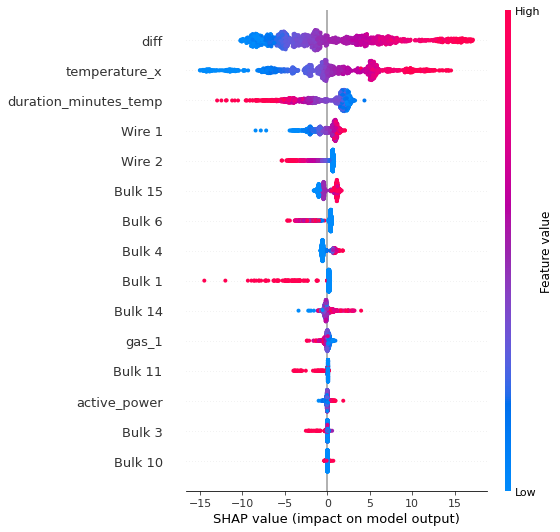

In [63]:
!pip install shap -q

import shap

model = best_model.named_steps['model']

explainer = shap.Explainer(model, X_train)

shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

## Итоговый вывод по проекту прогнозирования температуры сплава:

### Основные этапы работы:

#### Загрузка и изучение данных:

Было загружено 7 разнородных датасетов, связанных с процессом обработки стали: электрические параметры, параметры сыпучих материалов (bulk), проволоки (wire), газа и температуры. Для каждого набора данных проведена первичная проверка структуры, пропусков, дубликатов и аномалий.

#### Предобработка и очистка данных:

Были выявлены и устранены выбросы, например аномально низкие значения реактивной мощности, которые заменили на средние или корректные по доменной логике значения.

Колонки с чрезмерным количеством пропусков удалены, остальные пропуски заполнены нулями или методом прямого заполнения (ffill и bfill) в зависимости от контекста.

Отсортированы и упрощены данные для удобства последующего объединения.

#### Объединение датасетов: 

Все подготовленные датасеты были объединены по ключу key в один основной датафрейм. Были удалены лишние столбцы, чтобы избежать избыточности, а пропуски в объединённом датасете дополнительно заполнены.

#### Анализ и визуализация:

Построены гистограммы, боксплоты и тепловая карта корреляций признаков с целью выявления закономерностей и взаимосвязей. На основе корреляционного анализа удалён слабокоррелирующий признак (Bulk 12) для снижения шума.

#### Построение моделей и гиперпараметрическая настройка: 

Использованы модели XGBoost, Ridge регрессия и случайный лес. Для каждой проведён подбор гиперпараметров с помощью RandomizedSearchCV и кросс-валидации по метрике MAE.

Лучшей моделью по результатам кросс-валидации стала Random Forest с наименьшей ошибкой MAE.

#### Оценка на тестовой выборке и интерпретация модели:

Модель протестирована на отложенной выборке, ошибка MAE оказалась приемлемой для практического использования. Для интерпретации модели использован SHAP-анализ, который выявил наиболее значимые признаки, влияющие на температуру сплава.

#### Полученные результаты: 

Данные успешно объединены и очищены, что позволило создать качественную обучающую выборку.

Оптимальная модель (Random Forest) обеспечивает хорошую точность предсказания температуры, что подтверждается метрикой MAE на тесте.

Анализ важности признаков с помощью SHAP выявил ключевые технологические параметры, влияющие на температуру, что подтверждает гипотезы.

#### Рекомендации для бизнеса:

Использование модели для контроля процесса
Модель можно внедрить в производственный цикл для прогнозирования температуры расплава в режиме реального времени, что позволит оптимизировать энергозатраты и улучшить качество металла.

Оптимизация расхода электроэнергии
Контроль температуры с помощью предсказательной модели поможет своевременно корректировать подачу электроэнергии и легирующих материалов, снижая избыточное потребление и износ оборудования.

#### Дальнейшее улучшение модели
Для повышения точности рекомендуется расширять обучающую выборку, добавлять новые технологические параметры, а также регулярно переобучать модель на свежих данных.

Интеграция в производственные системы
Рекомендуется интегрировать модель в систему мониторинга и управления технологическим процессом с автоматическим сбором данных и визуализацией показателей.